# Geodata Attack - Using GPS

In [1]:
import skmob
from skmob.utils import constants
from skmob.utils import utils

from geopy.distance import distance
import pandas as pd
import numpy as np
import csv
import folium

## Preprocessing GPS Data

### Load data from file

In [2]:
gps = 'privamov/privamov-gps.csv'
gsm = 'privamov/privamov-gsm.csv'
wifi = 'privamov/privamov-wifi.csv'

Loading only a subset of data from `privamov-gps.csv` , by using `MAX_LINES` and `SKIP_LINES`

In [3]:
def formatGPS(file, MAX_LINES = 10**7, SKIP_LINES = 100):
    ids = []
    horodate = []
    lat = []
    long = []
    i = 0
    t = 0
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t', quotechar="'")
        for row in csv_reader:
            if t == SKIP_LINES:
                ids.append(row[0])
                horodate.append(row[1])
                lat.append(row[3])
                long.append(row[2])
                if i > MAX_LINES : 
                    break
                t=0
            else :
                t+=1
            i+=1
        d = { 'ID': ids, 'Horodate':horodate, 'Latitude':lat, 'Longitude':long}  
        df = pd.DataFrame(data=d)
    return df

### Build DataFrame & Quick Visualization

In [4]:
df_gps = formatGPS(gps)
df_gps.head()

,ID,Horodate,Latitude,Longitude
0,1,2014-10-04 08:41:32.161,43.4094416666667,3.68725
1,1,2014-10-04 08:42:22.18,43.4092883333333,3.68749333333333
2,1,2014-10-04 08:43:14.161,43.4094033333333,3.68728166666667
3,1,2014-10-04 08:44:06.176,43.4093516666667,3.68739166666667
4,1,2014-10-04 08:45:24.161,43.4091083333333,3.687645


Aggregating number of points by IDs

In [5]:
def get_unique_id(df):
    ids = df['ID']
    unique_id = set()
    for ident in ids:
        unique_id.add(ident)
    return unique_id  

In [48]:
unique_id = sorted(list(get_unique_id(df_gps)))
print(unique_id)

['1', '10', '107', '11', '12', '13', '14', '15', '16', '17', '19', '2', '20', '21', '22', '23', '24', '25', '26', '32', '37', '42', '44', '5', '6', '7', '8', '9', '98']


In [7]:
agg = df_gps.groupby('ID').size().reset_index(name='counts')
agg.sort_values(by='counts',ascending=False).head()

,ID,counts
0,1,27375
11,2,22068
24,6,13409
3,11,6473
26,8,5139


### Build SKMOB Object & Visualize trajectories

In [8]:
tdf = skmob.TrajDataFrame(df_gps, latitude='Latitude', longitude='Longitude', datetime='Horodate', user_id='ID')
print(tdf.head())

  uid                datetime        lat       lng
0   1 2014-10-04 08:41:32.161  43.409442  3.687250
1   1 2014-10-04 08:42:22.180  43.409288  3.687493
2   1 2014-10-04 08:43:14.161  43.409403  3.687282
3   1 2014-10-04 08:44:06.176  43.409352  3.687392
4   1 2014-10-04 08:45:24.161  43.409108  3.687645


In [9]:
tdf.dtypes

uid                 object
datetime    datetime64[ns]
lat                float64
lng                float64
dtype: object

**Visualise the raw trajectories on a map**

Plot the trajectories of `max_users=2` users.

To save memory, each trajectory is downsampled so that at most `max_points=2000` points are plotted.

In [10]:
map_f = tdf.plot_trajectory(max_users=2, max_points=2000)
map_f

Plot the first 10k points of the user 1's trajectory

In [11]:
maps = tdf[tdf['uid'] == '8'].plot_trajectory()
maps

## Filtering

Filter out all points with speed higher than `max_speed` km/h from the previous point.

In [12]:
from skmob.preprocessing import filtering

In [13]:
ftdf = filtering.filter(tdf, max_speed_kmh=400.)

In [14]:
ftdf.parameters

{'filter': {'function': 'filter',
  'max_speed_kmh': 400.0,
  'include_loops': False,
  'speed_kmh': 5.0,
  'max_loop': 6,
  'ratio_max': 0.25}}

Very few points have been filtered.

In [15]:
print('Points of the raw trajectory: %s'%len(tdf))
print('Points of the filtered trajectory: %s'%len(ftdf))

Points of the raw trajectory: 99010
Points of the filtered trajectory: 98753


**Inspect the filtered points**

In [16]:
merged = tdf.merge(ftdf, indicator=True, how='outer')
diff_df = merged[merged['_merge'] == 'left_only']

In [17]:
diff_df[:10]

,uid,datetime,lat,lng,_merge
3582,1,2014-10-20 13:03:46.240,45.676025,5.180532,left_only
5714,1,2014-11-24 15:09:05.342,45.497845,4.165382,left_only
5715,1,2014-11-24 15:10:00.391,45.465823,4.087710,left_only
6118,1,2014-11-25 09:30:04.933,45.388705,5.161213,left_only
11597,8,2014-11-29 13:22:23.589,44.785588,0.159285,left_only
11598,8,2014-11-29 13:22:48.599,44.778640,0.220728,left_only
11601,8,2014-11-29 13:24:04.591,44.758138,0.403972,left_only
11602,8,2014-11-29 13:24:29.599,44.751670,0.462723,left_only
11605,8,2014-11-29 13:25:45.588,44.729310,0.651957,left_only
11606,8,2014-11-29 13:26:10.601,44.722227,0.715895,left_only


Extract the filtered points between indexes 11597 and 11614.

In [18]:
imin = 11597 - 1
imax = 11614 + 1
dt_start = tdf.iloc[imin]['datetime']
dt_end = tdf.iloc[imax]['datetime']


filtered_tdf = ftdf[(ftdf['datetime'] >= dt_start) \
                 & (ftdf['datetime'] <= dt_end) \
                 & (ftdf['uid'] == '8')]

unfiltered_tdf = tdf[(tdf['datetime'] >= dt_start) \
                  & (tdf['datetime'] <= dt_end) 
                  & (tdf['uid'] == '8')]

In [19]:
filtered_tdf

,uid,datetime,lat,lng


In [20]:
unfiltered_tdf

,uid,datetime,lat,lng
11597,8,2014-11-29 13:22:23.589,44.785588,0.159285
11598,8,2014-11-29 13:22:48.599,44.778640,0.220728
11601,8,2014-11-29 13:24:04.591,44.758138,0.403972
11602,8,2014-11-29 13:24:29.599,44.751670,0.462723
11605,8,2014-11-29 13:25:45.588,44.729310,0.651957
11606,8,2014-11-29 13:26:10.601,44.722227,0.715895
11609,8,2014-11-29 13:27:26.592,44.699198,0.912335
11610,8,2014-11-29 13:27:51.641,44.691387,0.977267
11613,8,2014-11-29 13:29:07.588,44.668032,1.174598
11614,8,2014-11-29 13:29:32.604,44.660357,1.238972


Compute the speeds between consecutive points on the unfiltered trajectory

In [21]:
la_lo_dt = unfiltered_tdf[['lat', 'lng', 'datetime']].values

In [22]:
# average speed (km/h) between the last point not filtered and the following points

i0 = 0 
la0, lo0, dt0 = la_lo_dt[i0]
pd.DataFrame(
    [[dt0, dt , distance((la,lo), (la0, lo0)).km / ((dt - dt0).seconds / 3600) ] \
     for i,(la,lo,dt) in enumerate(la_lo_dt[i0+1:])], \
             columns=['time 0', 'time 1', 'speed (km/h)'])

,time 0,time 1,speed (km/h)
0,2014-11-29 13:22:23.589,2014-11-29 13:22:48.599,709.035674
1,2014-11-29 13:22:23.589,2014-11-29 13:24:04.591,698.895566
2,2014-11-29 13:22:23.589,2014-11-29 13:24:29.599,694.718703
3,2014-11-29 13:22:23.589,2014-11-29 13:25:45.588,707.592187
4,2014-11-29 13:22:23.589,2014-11-29 13:26:10.601,707.839260
5,2014-11-29 13:22:23.589,2014-11-29 13:27:26.592,717.725378
6,2014-11-29 13:22:23.589,2014-11-29 13:27:51.641,720.306782
7,2014-11-29 13:22:23.589,2014-11-29 13:29:07.588,727.924822
8,2014-11-29 13:22:23.589,2014-11-29 13:29:32.604,727.242587


All points with speed higher than `max_speed`=400. km/h have been filtered.

**Visualise the filtered points**

In [23]:
# Cut a buffer of 10 points around the filtered part
user_id = '8'

imin = 11597 - 10
imax = 11614 + 10
dt_start = tdf.iloc[imin]['datetime']
dt_end = tdf.iloc[imax]['datetime']

filtered_tdf = ftdf[(ftdf['datetime'] >= dt_start) \
                 & (ftdf['datetime'] <= dt_end) \
                 & (ftdf['uid'] == user_id)]

unfiltered_tdf = tdf[(tdf['datetime'] >= dt_start) \
                  & (tdf['datetime'] <= dt_end) \
                  & (tdf['uid'] == user_id)]

In [24]:
filtered_tdf

,uid,datetime,lat,lng
1033,8,2014-11-29 13:15:57.591,44.905252,-0.608083
1034,8,2014-11-29 13:17:11.588,44.890835,-0.513178


In [25]:
unfiltered_tdf

,uid,datetime,lat,lng
11587,8,2014-11-29 13:15:57.591,44.905252,-0.608083
11589,8,2014-11-29 13:17:11.588,44.890835,-0.513178
11597,8,2014-11-29 13:22:23.589,44.785588,0.159285
11598,8,2014-11-29 13:22:48.599,44.778640,0.220728
11601,8,2014-11-29 13:24:04.591,44.758138,0.403972
11602,8,2014-11-29 13:24:29.599,44.751670,0.462723
11605,8,2014-11-29 13:25:45.588,44.729310,0.651957
11606,8,2014-11-29 13:26:10.601,44.722227,0.715895
11609,8,2014-11-29 13:27:26.592,44.699198,0.912335
11610,8,2014-11-29 13:27:51.641,44.691387,0.977267


In [26]:
map_f = unfiltered_tdf.plot_trajectory(zoom=15, weight=10, opacity=0.5)
map_f = filtered_tdf.plot_trajectory(map_f=map_f, max_users=1)

map_f

* The thick line is the unfiltered trajectory (unfiltered_tdf)
* The thin line is the filtered trajectory (filtered_tdf)

## Compression

Reduce the number of points of the trajectory, preserving the structure.

Merge together all points that are closer than `spatial_radius_km`=0.2 kilometers from each other.

In [27]:
from skmob.preprocessing import compression

In [28]:
ctdf = compression.compress(ftdf, spatial_radius_km=0.2)
ctdf[:4]

,uid,datetime,lat,lng
0,1,2014-10-04 08:41:32.161,43.409325,3.687525
1,1,2014-10-08 07:16:42.104,45.775821,4.870866
2,1,2014-10-08 07:20:05.132,45.776488,4.873753
3,1,2014-10-08 07:23:27.105,45.778869,4.874576


The compressed trajectory has only a small fraction of the points of the filtered trajectory (less than 10%)

In [29]:
print('Points of the filtered trajectory: %s'%len(ftdf))
print('Points of the compressed trajectory: %s'%len(ctdf))

Points of the filtered trajectory: 98753
Points of the compressed trajectory: 7314


**Visualise the filtered and compressed trajectories**

Show the first 10000 points of the trajectory of the first user.

In [30]:
end_time = ftdf.iloc[10000]['datetime']

map_f = ftdf[ftdf['datetime'] < end_time].plot_trajectory(max_users=1, weight=5, \
                                            opacity=0.5, start_end_markers=False)

ctdf[ctdf['datetime'] < end_time].plot_trajectory(max_users=1, map_f=map_f, \
                                                  start_end_markers=False)

* The thick line is the filtered trajectory (ftdf)
* The thin line is the compressed trajectory (ctdf)

## Stop detection

Identify locations where the user spent at least minutes_for_a_stop minutes within a `distance spatial_radius_km` $\times$ `stop_radius_factor`, from a given point.

A new column `leaving_datetime` is added, indicating the time when the user departs from the stop.

In [31]:
from skmob.preprocessing import detection

In [32]:
stdf = detection.stops(ctdf, stop_radius_factor=0.5, \
            minutes_for_a_stop=20.0, spatial_radius_km=0.2, 
                       leaving_time=True)
stdf[:4]

,uid,datetime,lat,lng,leaving_datetime
0,1,2014-10-04 08:41:32.161,43.409325,3.687525,2014-10-08 07:16:42.104000
1,1,2014-10-08 07:36:04.125,45.786668,4.879794,2014-10-08 16:03:08.105000
2,1,2014-10-08 16:30:54.132,45.771043,4.869805,2014-10-09 07:17:04.987000
3,1,2014-10-09 07:44:50.970,45.787747,4.879850,2014-10-09 10:21:40.969000


**Visualise the compressed trajectory and the stops**

Click on the stop markers to see a pop up with:

* User ID
* Coordinates of the stop (click to see the location on Google maps)
* Arrival time
* Departure time

In [33]:
map_f = ctdf.plot_trajectory(max_points=1000, hex_color=-1, start_end_markers=False)
stdf.plot_stops(map_f=map_f, hex_color=-1)

## Clustering stops

Stops are clustered by spatial proximity using DBSCAN.

The new column cluster is added to the Stops TrajectoryDataFrame, where the value correspond to the cluster ID each stop belong to.

Clusters IDs are integers (0, 1, ...): 0 is the most visited cluster, 1 is the second most visited, ...

In [34]:
from skmob.preprocessing import clustering

In [35]:
cstdf = clustering.cluster(stdf, cluster_radius_km=0.1, min_samples=1)
cstdf[:4]

,uid,datetime,lat,lng,leaving_datetime,cluster
0,1,2014-10-04 08:41:32.161,43.409325,3.687525,2014-10-08 07:16:42.104,16
1,1,2014-10-08 07:36:04.125,45.786668,4.879794,2014-10-08 16:03:08.105,0
2,1,2014-10-08 16:30:54.132,45.771043,4.869805,2014-10-09 07:17:04.987,1
3,1,2014-10-09 07:44:50.970,45.787747,4.879850,2014-10-09 10:21:40.969,107


**Visualise the compressed trajectory and stops: stops in the same clusters have the same color.**

Click on the stop markers to see a pop up with:

* User ID
* Cluster ID
* Coordinates of the stop (click to see the location on Google maps)
* Arrival time
* Departure time

In [36]:
map_f = ctdf[ctdf['uid'] == '1'].plot_trajectory(max_points=None, \
                                               hex_color='#000000', start_end_markers=False)
cstdf[stdf['uid'] == '1'].plot_stops(map_f=map_f)

**Visualise a user's diary**

C:\Users\LENOVO\Anaconda3\envs\skmob\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


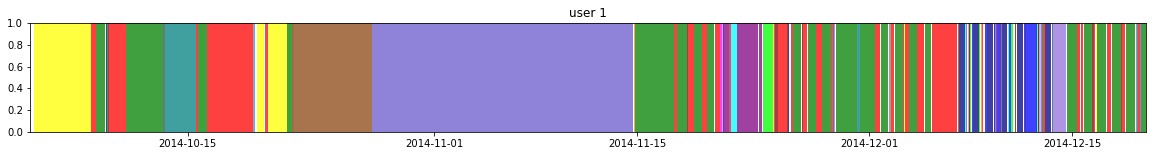

In [37]:
user = '1'
start_datetime = pd.to_datetime('2014-10-04 030000')
end_datetime = pd.to_datetime('2014-12-20 030000')
ax = cstdf.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

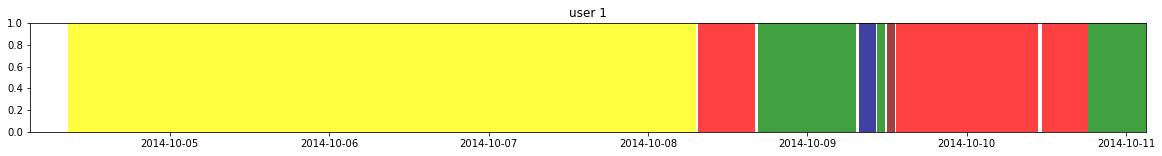

In [38]:
user = '1'
start_datetime = pd.to_datetime('2014-10-04 030000')
end_datetime = pd.to_datetime('2014-10-11 030000')
ax = cstdf.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

## Split trajectory into daily trajectories

In [39]:
import skmob
from skmob.utils import utils
from skmob.preprocessing import filtering, compression, detection, clustering

In [40]:
# Re-run all the preprocessing operations in one cell

tdf = skmob.TrajDataFrame(df_gps, latitude='Latitude', longitude='Longitude', datetime='Horodate', user_id='ID') 
ftdf = filtering.filter(tdf, max_speed_kmh=400.)
ctdf = compression.compress(ftdf, spatial_radius_km=0.2)
stdf = detection.stops(ctdf, stop_radius_factor=0.5, \
            minutes_for_a_stop=20.0, spatial_radius_km=0.2, leaving_time=True)
cstdf = clustering.cluster(stdf, cluster_radius_km=0.1, min_samples=1)

In [41]:
groups = utils.group_df_by_time(cstdf[cstdf['uid'] == '1'], 
                        offset_value=3, offset_unit='hours', add_starting_location=True)
groups[:3]

[  uid                datetime        lat       lng        leaving_datetime  \
 0   1 2014-10-04 08:41:32.161  43.409325  3.687525 2014-10-08 07:16:42.104   
 
    cluster  
 0       16  ,
   uid                datetime        lat       lng        leaving_datetime  \
 0   1 2014-10-04 08:41:32.161  43.409325  3.687525 2014-10-08 07:16:42.104   
 1   1 2014-10-08 07:36:04.125  45.786668  4.879794 2014-10-08 16:03:08.105   
 2   1 2014-10-08 16:30:54.132  45.771043  4.869805 2014-10-09 07:17:04.987   
 
    cluster  
 0       16  
 1        0  
 2        1  ,
   uid                datetime        lat       lng        leaving_datetime  \
 0   1 2014-10-08 16:30:54.132  45.771043  4.869805 2014-10-09 07:17:04.987   
 1   1 2014-10-09 07:44:50.970  45.787747  4.879850 2014-10-09 10:21:40.969   
 2   1 2014-10-09 10:25:02.970  45.785268  4.873731 2014-10-09 11:44:07.969   
 3   1 2014-10-09 12:00:48.015  45.784143  4.873661 2014-10-09 13:12:34.993   
 4   1 2014-10-09 13:15:57.049  45.786349

**Visualise the diaries of each sub-trajectory**

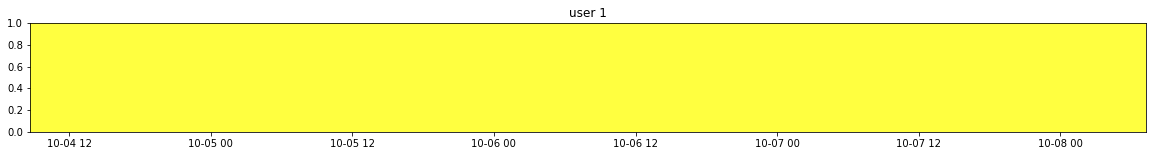

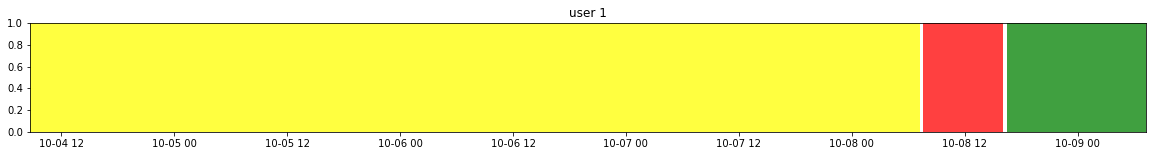

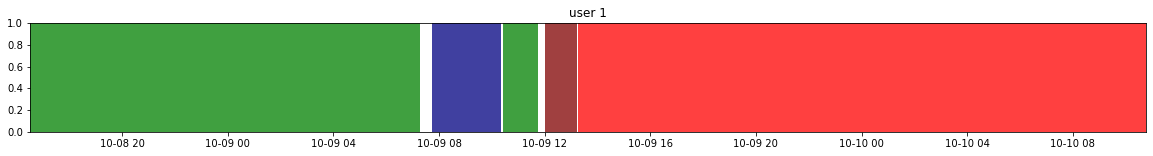

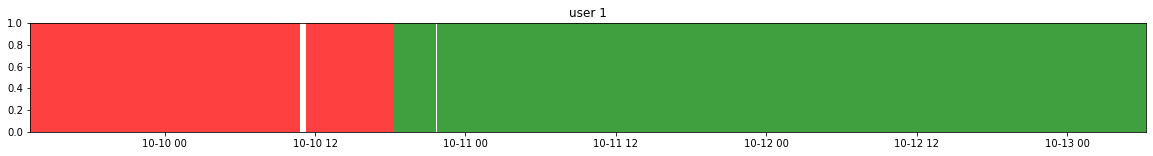

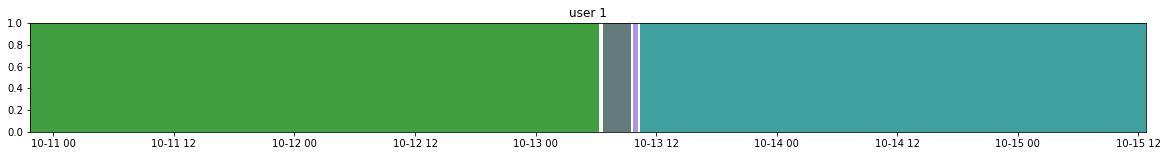

In [42]:
for tdf in groups[:5]:
    user = tdf['uid'].iloc[0]
    ax = tdf.plot_diary(user)

## Routing

Using OSMnx and networkx (taken from https://medium.com/@bobhaffner/osmnx-intro-and-routing-1fd744ba23d8).

In [43]:
import osmnx as ox
import folium

In [44]:
start_i = 0
dt_start = cstdf.iloc[start_i]['leaving_datetime']
dt_end = cstdf.iloc[start_i + 1]['datetime']
user_id = cstdf.iloc[start_i]['uid']

dt_start, dt_end

(Timestamp('2014-10-08 07:16:42.104000'),
 Timestamp('2014-10-08 07:36:04.125000'))

In [45]:
tdf1 = ftdf[(ftdf['datetime'] >= dt_start) & \
            (ftdf['datetime'] <= dt_end) & \
            (ftdf['uid'] == user_id)]
tdf1.plot_trajectory()